# CLASSIFICATION : Color 32x32

In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 30
num_classes = 10
batch_size = 100
learning_rate = 0.01

In [2]:
""" Custom datatset loader
    based on https://github.com/utkuozbulak/pytorch-custom-dataset-examples
"""
import pandas as pd
import imageio

class SimpleDataset():
    def __init__(self, data_path, csv_name, transform = None ):
        """
        Args:
            data_path (string): path to the folder where images and csv files are located
            csv_name (string): name of the csv lablel file
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Set path
        self.data_path = data_path
        
        # Read the csv file
        self.data_info = pd.read_csv(data_path + csv_name, header=0)
       
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        # Calculate len
        self.data_len = len(self.data_info.index)
        
    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        # Open image
        a=single_image_name[:-3] + "png"
        single_image_name=a
        img_as_img = imageio.imread(self.data_path + single_image_name)
        # Open segmented mask
        a = single_image_name[:2] + "seg" + single_image_name[2:]
        imseg_name = a[:-3] + "png"
        imgsg_as_img = imageio.imread(self.data_path + imseg_name)
        
        
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]
        
        return (img_as_img, single_image_label, imgsg_as_img)

    def __len__(self):
        return self.data_len

In [3]:
mydata = SimpleDataset( "./data2/", "labels.csv")

#splitting into images and labels 
X  = []
y  = []
Xs = []
for i in range(len(mydata)):
    X.append(mydata[i][0])
    y.append((mydata[i][1]))
    Xs.append(mydata[i][2])


#converting into numpy arrays to enable easy reshaping and other array operations
    
X  = np.asarray(X)
Xs = np.asarray(Xs)
print("Shape of the input image", X.shape, Xs.shape)
y= np.asarray(y)

X  = np.swapaxes(X,1,3)
X  = np.swapaxes(X,2,3)
print("Shape of the input image", X.shape, Xs.shape,y.shape)

Shape of the input image (5000, 32, 32, 3) (5000, 32, 32)
Shape of the input image (5000, 3, 32, 32) (5000, 32, 32) (5000,)


In [4]:
Xtr=X[:3500,:,:,:]/255
Xstr=Xs[:3500,:,:]/255
ytr=y[:3500]

Xval=X[3500:4000,:,:,:]/255 #need to change validation size for 32x32 & 64x64 images
Xsval=Xs[3500:4000,:,:]/255
yval=y[3500:4000]

Xte=X[-1000:,:,:,:]/255 #need to change test size for 32x32 & 64x64 images
Xste=Xs[-1000:,:,:]/255
yte=y[-1000:]


print(Xtr.shape,Xstr.shape,ytr.shape)
print(Xval.shape,Xsval.shape,yval.shape)
print(Xte.shape,Xste.shape,yte.shape)

(3500, 3, 32, 32) (3500, 32, 32) (3500,)
(500, 3, 32, 32) (500, 32, 32) (500,)
(1000, 3, 32, 32) (1000, 32, 32) (1000,)


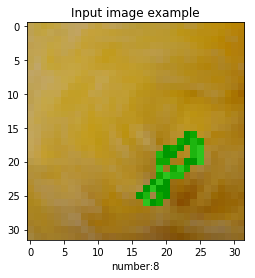

In [5]:
x=np.swapaxes(Xtr,1,3)
x=np.swapaxes(x,1,2)
plt.title("Input image example")
plt.xlabel("number:{}" .format(ytr[0]))
plt.imshow(x[0])

In [6]:
import torch.utils.data as data_utils
batch_size = 100
'''
inputs and segs are your data. 
'''
targets=ytr

inputs = torch.from_numpy(Xtr).float()
targets = torch.from_numpy(targets).long()
segs    = torch.from_numpy(Xstr).float()

print('Size of inputs: {}'. format(inputs.shape))
print('Size of ground truth: {}'. format(segs.shape))
print(targets.shape)

# Dataloader
trainset = data_utils.TensorDataset(inputs,targets)
train_loader = torch.utils.data.DataLoader(trainset, batch_size= batch_size, 
                                          shuffle=True, drop_last=True)

Size of inputs: torch.Size([3500, 3, 32, 32])
Size of ground truth: torch.Size([3500, 32, 32])
torch.Size([3500])


In [7]:
targets=yval
inputs = torch.from_numpy(Xval).float()
targets = torch.from_numpy(targets).long()
segs    = torch.from_numpy(Xsval).float()

print('Size of inputs: {}'. format(inputs.shape))
print('Size of ground truth: {}'. format(segs.shape))
print(targets.shape)

# Dataloader
valset = data_utils.TensorDataset(inputs, targets)
val_loader = torch.utils.data.DataLoader(valset, batch_size= batch_size, 
                                          shuffle=False, drop_last=True)

Size of inputs: torch.Size([500, 3, 32, 32])
Size of ground truth: torch.Size([500, 32, 32])
torch.Size([500])


In [8]:
targets=yte
inputs = torch.from_numpy(Xte).float()
targets = torch.from_numpy(targets).long()
segs    = torch.from_numpy(Xste).float()

print('Size of inputs: {}'. format(inputs.shape))
print('Size of ground truth: {}'. format(segs.shape))
print(targets.shape)

# Dataloader
testset = data_utils.TensorDataset(inputs, targets)
test_loader = torch.utils.data.DataLoader(testset, batch_size= 1000, 
                                          shuffle=False, drop_last=True)

Size of inputs: torch.Size([1000, 3, 32, 32])
Size of ground truth: torch.Size([1000, 32, 32])
torch.Size([1000])


In [9]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(8*8*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Model Summary

In [10]:
from torchsummary import summary
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]           1,216
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         MaxPool2d-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 32, 16, 16]          12,832
       BatchNorm2d-6           [-1, 32, 16, 16]              64
              ReLU-7           [-1, 32, 16, 16]               0
         MaxPool2d-8             [-1, 32, 8, 8]               0
            Linear-9                   [-1, 10]          20,490
Total params: 34,634
Trainable params: 34,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.61
Params size (MB): 0.13
Estimated Total Size (MB): 0.75
---------------------------------------------

In [11]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 85 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

In [12]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 30.3 %


In [13]:
from sklearn.metrics import confusion_matrix

out=outputs.data.cpu().detach().numpy()
lab=labels.data.cpu().detach().numpy()

_, predicted = torch.max(outputs.data, 1)

cfm = confusion_matrix(lab, predicted.cpu().detach().numpy())

In [14]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


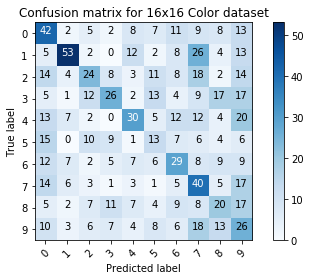

In [15]:
    plot_confusion_matrix(cfm, classes=range(10), 
                      title='Confusion matrix for 16x16 Color dataset')

In [16]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

# Model modification / Observation

The sizes of convolution layers were adjusted to fit the size of images in the dataset. Particularly, channel was changed to 3 and the dimensions of the final fully connected layer was changed to 8 * 8 * 32.

Different values of hyperparameters learning_rate and epochs were tried. The architecture was changed to add additional convolution blocks (conv + batch norm + activation + maxpool) but it did not improve the performance of the classifier.

Despite trying differnt architectures and hyperparameter values, the best performance obtained was around 35%